In [4]:
#### Imports

# ==========================================
# 1. Data Reading and Processing
# ==========================================


from pathlib import Path # for reading the data
import numpy as np    # for storing the data
np.set_printoptions(precision=2)
import cv2 # read image and resize it
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict, StratifiedKFold ,GridSearchCV # Tests ,Kfolds and splitting , run models
from sklearn.pipeline import Pipeline               # pipeline (split,scale,train)


# ==========================================
# 2. MODEL , Metrics and Plotting
# ==========================================
from sklearn.neural_network import MLPClassifier ## neural network
from sklearn.linear_model import LogisticRegression, LinearRegression  ## Regression (linear and logistic)
from sklearn.naive_bayes import GaussianNB  ## NaiveBayes
from sklearn.multiclass import OneVsRestClassifier  ## classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , make_scorer  # metrics and score
import matplotlib.pyplot as plt  # plotting and visualizing
import seaborn as sns
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format) ## utility for storing scores
# display options
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import time # for computation analysis


# # ==========================================
# # 3. utils
# # ==========================================

# import warnings
# from sklearn.exceptions import ConvergenceWarning

In [28]:
def load_dataset(root_path):
    """
    Reads DIDA dataset from folders '0' through '9'.
    Returns:
        X: shape (10000, 784) - Flattened images
    """
    print(f"Loading data from: {root_path}")
    start_time= time.time()
    # 1. Pre-allocate Memory
    # 10,000 images, 28x28 = 784 features.
    # using 'uint8' (0-255) saves RAM. We will normalize to floats later.
    X = np.zeros((10000, 784), dtype=np.float32)

    global_index = 0

    # 2. Iterate through folders 0 to 9
    for digit in range(10):
        folder_path = root_path/str(digit)   # path object use "/" for subdirectory
        # Get list of files
        if not Path.exists(folder_path):
            raise FileNotFoundError(f"Folder {folder_path} not found!")

        # OS file order can be random. just to ensure reproducibility.
        files = sorted(folder_path.iterdir())

        # Check: If a folder has the right number of images
        if len(files) != 1000:
            raise ValueError(f"Folder '{digit}' has {len(files)} images, but expected 1000. Check your data!")

        # 3. Read images
        for filename in files:
            img_path = folder_path/filename

            # Read as Grayscale (ignore color channels if any)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            # resize image
            img = cv2.resize(img, (28, 28))

            # Flatten: Convert (28, 28) matrix -> (784,) vector
            X[global_index] = img.flatten()
            global_index += 1
    elapsed_time= time.time() - start_time
    print(f"Successfully loaded {global_index} images in {elapsed_time} seconds.")

    return X

In [29]:
def preprocess_and_split(X, y):

    X_normalized = X / 255.0 ## normalize values between zero and 1 # important note that we divided by float number so no round happens !!! critical step

    #Split data into training (80%) and testing (20%)
    # Stratify ensures we keep the same balance of digits 0-9 in both sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y, test_size=0.20, random_state=42, stratify=y
    )

    print(f"Training Set: {X_train.shape}")
    print(f"Test Set (Held Out): {X_test.shape}")

    return X_train, X_test, y_train, y_test

In [30]:
# ==========================================
# 4. DEFINING MODELS and hyper paramters
# ==========================================
def get_experiment_setup():
    models_config = {
        'NaiveBayes':{},
        'LinearReg_OvA':{},
        'LogisticReg':{},
        'MLP':{}
    }


    # 1. Naive Bayes
    models_config['NaiveBayes'] = {
        'model': GaussianNB(),
        'params': {} # No params for GaussianNB
    }


    # 2. Linear Regression (One-Vs-All)
    models_config['LinearReg_OvA'] = {
        'model': OneVsRestClassifier(LinearRegression()),
        'params': {} # No hyperparameters to tune for standard OLS
    }




    # 3. Logistic Regression
    models_config['LogisticReg'] = {
        'model': LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42),  # convergence criteria -> 1000 iterations , and tol = 1e-4 (default)
        'params': {
            'C': [1.0, 10.0] # We can tune regularization strength the smaller the value , the bigger the reugulariztion
        }
    }

    
    # 4. MLP (Neural Network) - Hyperparameter Tuning
    # We test 2 different architectures
    models_config['MLP'] = {
        'model': MLPClassifier(random_state=42,max_iter=2000),
        'params': {
            'hidden_layer_sizes': [(300, 150,100,50,10), (100, 75,50,25,5)] # Architecture
        }
    }

    


    return models_config

In [31]:
# load data

root_path= Path.cwd()/'DIDA'  # Base folder
X = load_dataset(root_path)

Loading data from: S:\Off-College\My_Projects\JupyterNotebookProjects\Other Projects\ML Project\DIDA
Successfully loaded 10000 images in 141.8680145740509 seconds.


In [32]:
# target creation and splitting
y = np.arange(0,10).repeat(1000)   # create target values from 0 to 9 repeated 1000 times (number of files) as read from folders

X_train, X_test, y_train, y_test = preprocess_and_split(X, y)

Training Set: (8000, 784)
Test Set (Held Out): (2000, 784)


In [33]:
setup = get_experiment_setup() # configs for gridsearch
model_index= list(setup.keys())    # index of models ordering (just for display)
best_estimators = {} # To store the winners
cv_best_result_summary = []  # store best of each model 
cv_all_results_summary = []  # store all resutls of all models with different parameters
# Define the 4 metrics we want to track
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro', # Macro for multiclass
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

PHASE 1: Hyperparameter Tuning & Cross-Validation Analysis

Running GridSearchCV for NaiveBayes...
   -> Best Params: {}
   -> Mean Accuracy: 0.5060
   -> Training Time: 0.1030s
   -> Generating Confusion Matrix...


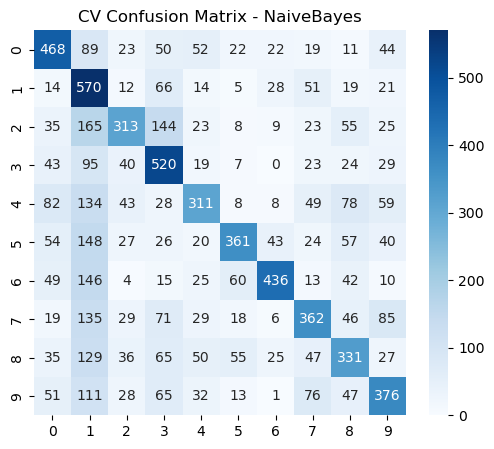

   -> Elapsed Time for NaiveBayes : 16.175161600112915 seconds

Running GridSearchCV for LinearReg_OvA...
   -> Best Params: {}
   -> Mean Accuracy: 0.6390
   -> Training Time: 4.2357s
   -> Generating Confusion Matrix...


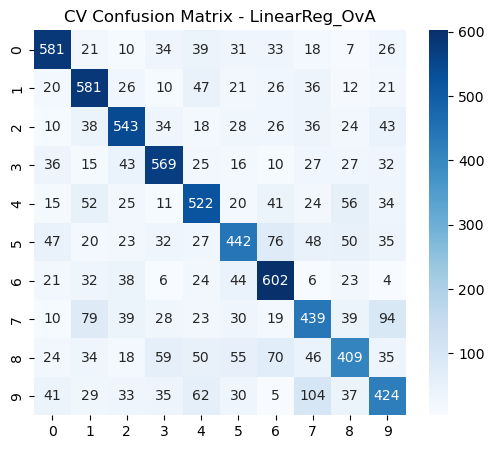

   -> Elapsed Time for LinearReg_OvA : 20.42999267578125 seconds

Running GridSearchCV for LogisticReg...
   -> Best Params: {'C': 1.0}
   -> Mean Accuracy: 0.7438
   -> Training Time: 17.7710s
   -> Generating Confusion Matrix...


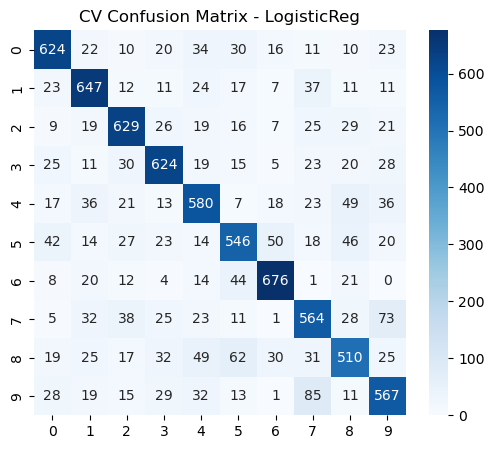

   -> Elapsed Time for LogisticReg : 62.28835582733154 seconds

Running GridSearchCV for MLP...
   -> Best Params: {'hidden_layer_sizes': (300, 150, 100, 50, 10)}
   -> Mean Accuracy: 0.8234
   -> Training Time: 297.2482s
   -> Generating Confusion Matrix...


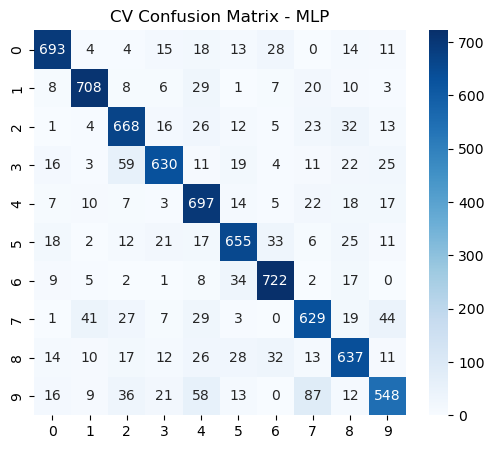

   -> Elapsed Time for MLP : 1135.742957353592 seconds
Cell Execution took 1234.6364674568176 seconds


In [34]:
print("="*60)
print("PHASE 1: Hyperparameter Tuning & Cross-Validation Analysis")
print("="*60)

#with warnings.catch_warnings():
   # Only ignore warnings of convergence error due to hyperparamters tuning
   #warnings.filterwarnings("ignore", category=ConvergenceWarning)
running_time=0 # compute cell execution time ( just for debugging)
for name, config in setup.items():
    print(f"\nRunning GridSearchCV for {name}...")

    # 1. Configure GridSearch
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,                         # 5-Fold Stratified CV
        scoring=scoring_metrics,      # Capture ALL 4 metrics
        refit='f1',             # Optimized for Accuracy
        n_jobs=-1,
        return_train_score=False
    )
    # compute time 
    start_time=time.time()
    # 2. Run Training
    grid.fit(X_train, y_train)

    # 3. Capture Best Results
    best_estimators[name] = grid.best_estimator_
    results = grid.cv_results_
    best_index = grid.best_index_ # Index of the winning combo
    # 4. Extract Metrics for the *Winner* only
    # GridSearch returns metrics for ALL combinations. We only want the best one.
    best_summary = {
        'Model': name,
        'Best Params': grid.best_params_,
        'Mean Accuracy': results['mean_test_accuracy'][best_index],
        'Mean Precision': results['mean_test_precision'][best_index],
        'Mean Recall': results['mean_test_recall'][best_index],
        'Mean F1': results['mean_test_f1'][best_index],
        'Standard Deviation':  results['std_test_f1'][best_index],
        'Training Time (s)': results['mean_fit_time'][best_index]
    }

    all_summary = {
        'Model': name,
        'Params': results['params'],
        'Mean Accuracy': results['mean_test_accuracy'],
        'Mean Precision': results['mean_test_precision'],
        'Mean Recall': results['mean_test_recall'],
        'Mean F1': results['mean_test_f1'],
        'Standard Deviation':  results['std_test_f1'],
        'Training Time (s)': results['mean_fit_time']
    }
    cv_best_result_summary.append(best_summary)
    cv_all_results_summary.append(all_summary)
    print(f"   -> Best Params: {grid.best_params_}")
    print(f"   -> Mean Accuracy: {best_summary['Mean Accuracy']:.4f}")
    print(f"   -> Training Time: {best_summary['Training Time (s)']:.4f}s")

    # 5. Generate Confusion Matrix (Separately via cross_val_predict)
    print("   -> Generating Confusion Matrix...")
    y_pred_cv = cross_val_predict(grid.best_estimator_, X_train, y_train, cv=5)
    cm = confusion_matrix(y_train, y_pred_cv)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'CV Confusion Matrix - {name}')
    plt.show()
    end_time=time.time()
    elapsed_time=end_time - start_time
    running_time+=elapsed_time
    print(f'   -> Elapsed Time for {name} : {elapsed_time} seconds')
print(f'Cell Execution took {running_time} seconds')    

In [35]:
#2. utility function to flattening and add the result to dataframe
def flatten_all_cv_results(cv_all_results):
    flat_rows = []

    for entry in cv_all_results:
        # A. Determine how many experiments are in this entry
        # We look at 'Mean Accuracy' to count how many values are in the array
        # np.atleast_1d ensures it works even if NaiveBayes was a scalar float
        num_experiments = len(np.atleast_1d(entry['Mean Accuracy']))

        # B. Loop through each experiment (0, 1...)
        for i in range(num_experiments):
            row = {}

            # C. Extract the data for this specific experiment
            for key, val in entry.items():
                # If it's a scalar (Model Name or Best Params), copy it directly
                if key in ['Model']:
                    row[key] = val
                # If it's an array/list (The Scores), take the i-th item
                else:
                    # Convert to array to be safe, then index
                    val_array = np.atleast_1d(val)
                    row[key] = val_array[i]

            flat_rows.append(row)

    return flat_rows


In [38]:
# Create a DataFrame for the Technical Report
df_best_results = pd.DataFrame(cv_best_result_summary)
df_all_results = pd.DataFrame(flatten_all_cv_results(cv_all_results_summary))

In [39]:
display(df_all_results)

,Model,Params,Mean Accuracy,Mean Precision,Mean Recall,Mean F1,Standard Deviation,Training Time (s)
0,NaiveBayes,{},0.51,0.54,0.51,0.51,0.01,0.10
1,LinearReg_OvA,{},0.64,0.64,0.64,0.64,0.01,4.24
2,LogisticReg,{'C': 1.0},0.74,0.74,0.74,0.74,0.01,17.77
3,LogisticReg,{'C': 10.0},0.69,0.69,0.69,0.69,0.01,26.85
4,MLP,"{'hidden_layer_sizes': (300, 150, 100, 50, 10)}",0.82,0.83,0.82,0.82,0.02,297.25
5,MLP,"{'hidden_layer_sizes': (100, 75, 50, 25, 5)}",0.10,0.01,0.10,0.02,0.00,10.47


In [43]:
print("="*60)
print("PHASE 2: Final Test Set Evaluation (The Vault)")
print("="*60)
all_classification_report=[]
final_metrics = []
target_names=[f"Digit {i}" for i in range(0,10)]
for name, model in best_estimators.items():
    print(f"\nEvaluating Best {name} on Test Set...")

    # 1. Predict (Model is already refitted on X_train by GridSearchCV)
    y_pred = model.predict(X_test)

    # 2. Calculate Final Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"   -> Final Test Accuracy: {acc:.4f}")

    # Store for final report
    final_metrics.append({
        'Model': name,
        'Test Accuracy': acc
    })

    # Full Classification Report
    all_classification_report.append(classification_report(y_test, y_pred,target_names=target_names,output_dict=True))

# Final Comparison Table
metrics_df=pd.DataFrame(final_metrics)
display(metrics_df)

PHASE 2: Final Test Set Evaluation (The Vault)

Evaluating Best NaiveBayes on Test Set...
   -> Final Test Accuracy: 0.5075

Evaluating Best LinearReg_OvA on Test Set...
   -> Final Test Accuracy: 0.6635

Evaluating Best LogisticReg on Test Set...
   -> Final Test Accuracy: 0.7555

Evaluating Best MLP on Test Set...
   -> Final Test Accuracy: 0.8470


,Model,Test Accuracy
0,NaiveBayes,0.51
1,LinearReg_OvA,0.66
2,LogisticReg,0.76
3,MLP,0.85


C:\Users\am787\AppData\Local\Temp\ipykernel_12648\442440016.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='Model', y='Accuracy', palette='viridis')


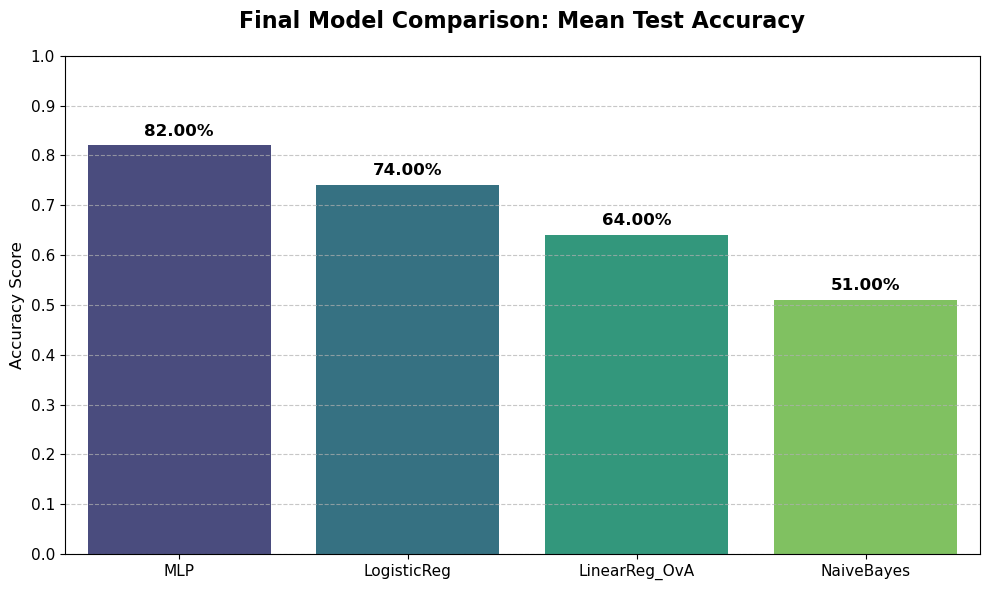

In [9]:
#Bar Chart for Time-accurcy trade-off

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data_bar = {
    'Model': ['NaiveBayes' ,'LinearReg_OvA', 'LogisticReg','MLP'  ],
    # Using the 'Mean Accuracy' values you provided
    'Accuracy': [0.51, 0.64, 0.74, 0.82]
}

# Create a DataFrame and sort it so the best model is first
df_plot = pd.DataFrame(data_bar)
df_plot = df_plot.sort_values(by='Accuracy', ascending=False)

# 2. Create the Chart
plt.figure(figsize=(10, 6))

# Use Seaborn for a nice looking barplot
ax = sns.barplot(data=df_plot, x='Model', y='Accuracy', palette='viridis')

# 3. Add Styling and Labels
plt.title('Final Model Comparison: Mean Test Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('') # Remove the 'Model' label as it's redundant
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.yticks(np.linspace(0,1,11)) # Set the y-axis from 0% to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Add the exact numbers on top of each bar
for p in ax.patches:
    # Calculate the text position
    height = p.get_height()
    ax.annotate(f'{height:.2%}',  # Format as percentage (e.g., 83.38%)
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black',
                xytext=(0, 5),
                textcoords='offset points')

# 5. Show the plot
plt.tight_layout()
plt.show()

In [ ]:
for i,cf in enumerate(all_classification_report):
 cr_df=pd.DataFrame(cf)
 cr_df=cr_df.transpose()
 styled_cr_df=cr_df.style.set_caption(model_index[i]).format(precision=2)
 display(styled_cr_df)
 #display(cr_df)

In [84]:
display(cr_df.transpose())

,Digit 0,Digit 1,Digit 2,Digit 3,Digit 4,Digit 5,Digit 6,Digit 7,Digit 8,Digit 9,accuracy,macro avg,weighted avg
precision,0.90,0.93,0.83,0.77,0.87,0.76,0.86,0.92,0.83,0.85,0.85,0.85,0.85
recall,0.92,0.84,0.87,0.90,0.80,0.93,0.86,0.80,0.78,0.78,0.85,0.85,0.85
f1-score,0.91,0.88,0.85,0.83,0.83,0.84,0.86,0.85,0.80,0.81,0.85,0.85,0.85
support,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,0.85,2000.00,2000.00


In [85]:
all_classification_report

[{'Digit 0': {'precision': 0.5609756097560976,
   'recall': 0.575,
   'f1-score': 0.5679012345679012,
   'support': 200.0},
  'Digit 1': {'precision': 0.308411214953271,
   'recall': 0.66,
   'f1-score': 0.42038216560509556,
   'support': 200.0},
  'Digit 2': {'precision': 0.5666666666666667,
   'recall': 0.34,
   'f1-score': 0.425,
   'support': 200.0},
  'Digit 3': {'precision': 0.47674418604651164,
   'recall': 0.615,
   'f1-score': 0.537117903930131,
   'support': 200.0},
  'Digit 4': {'precision': 0.5957446808510638,
   'recall': 0.42,
   'f1-score': 0.49266862170087977,
   'support': 200.0},
  'Digit 5': {'precision': 0.6197183098591549,
   'recall': 0.44,
   'f1-score': 0.5146198830409356,
   'support': 200.0},
  'Digit 6': {'precision': 0.703030303030303,
   'recall': 0.58,
   'f1-score': 0.6356164383561644,
   'support': 200.0},
  'Digit 7': {'precision': 0.5813953488372093,
   'recall': 0.5,
   'f1-score': 0.5376344086021505,
   'support': 200.0},
  'Digit 8': {'precision': 0

In [82]:
all_classification_report[3]

{'Digit 0': {'precision': 0.8975609756097561,
  'recall': 0.92,
  'f1-score': 0.908641975308642,
  'support': 200.0},
 'Digit 1': {'precision': 0.9285714285714286,
  'recall': 0.845,
  'f1-score': 0.8848167539267016,
  'support': 200.0},
 'Digit 2': {'precision': 0.8285714285714286,
  'recall': 0.87,
  'f1-score': 0.848780487804878,
  'support': 200.0},
 'Digit 3': {'precision': 0.7692307692307693,
  'recall': 0.9,
  'f1-score': 0.8294930875576036,
  'support': 200.0},
 'Digit 4': {'precision': 0.8736263736263736,
  'recall': 0.795,
  'f1-score': 0.8324607329842932,
  'support': 200.0},
 'Digit 5': {'precision': 0.7622950819672131,
  'recall': 0.93,
  'f1-score': 0.8378378378378378,
  'support': 200.0},
 'Digit 6': {'precision': 0.864321608040201,
  'recall': 0.86,
  'f1-score': 0.8621553884711779,
  'support': 200.0},
 'Digit 7': {'precision': 0.9190751445086706,
  'recall': 0.795,
  'f1-score': 0.8525469168900804,
  'support': 200.0},
 'Digit 8': {'precision': 0.8288770053475936,
  '